In [24]:
import pandas as pd
import numpy as np

from scorta.recsys.candidate_generate import Candidate, CandidateMerger
from atma_16.dataset.dataset import AtmaData16Loader
from pathlib import Path
from atma_16.utils.polars_utils import min_max_scaler, over_rank
import polars as pl
from typing import Literal
import polars.selectors as cs

In [25]:
input_dir = Path("../input")
candidate_dir = input_dir / "candidate"
candidate_dir.mkdir(exist_ok=True)

feature_dir = input_dir / "feature"
feature_dir.mkdir(exist_ok=True)

exp_name = "003_add_features"
output_dir = Path("../output") / exp_name
output_dir.mkdir(parents=True, exist_ok=True)

dl = AtmaData16Loader(input_dir)
train_log = dl.load_train_log()

yado = dl.load_yado()
target_df = dl.load_train_label().with_columns(pl.lit(1).alias("target"))

In [26]:
from atma_16.candidate.candidate import LastSeenedCandidate, PopularAtCDCandidate

train_candidates = [
    LastSeenedCandidate(dl, candidate_dir, target_df=target_df),
    PopularAtCDCandidate(dl, candidate_dir, target_df=target_df),
]
test_candidates = [
    LastSeenedCandidate(dl, candidate_dir, mode="test"),
    PopularAtCDCandidate(dl, candidate_dir, mode="test"),
]

cands_dic = {"train": train_candidates, "test": test_candidates}

# for mode, candidates in cands_dic.items():
#     for cand in candidates:
#         df = cand.generate()
#         cand.save(df)
#         print(cand.evaluator.evaluate(df, cand.class_name))

#     cm = CandidateMerger(
#         dl, candidates, output_dir=candidate_dir, mode=mode, target_df=target_df if mode == "train" else None
#     )
#     merged_df = cm.merge()
#     cm.save(merged_df)

In [27]:
train_df = CandidateMerger(dl, train_candidates, output_dir=candidate_dir, mode="train").load()
test_df = CandidateMerger(dl, test_candidates, output_dir=candidate_dir, mode="test").load()
train_label = dl.load_train_label().with_columns(pl.lit(1).alias("label"))

train_df = train_df.join(train_label, on=["session_id", "yad_no"], how="left").with_columns(
    pl.col("label").fill_null(0)
)

In [28]:
# yado_feat = dl.load_yado().select(~cs.string())
# train_df = train_df.join(yado_feat, how="left", on="yad_no")
# test_df = test_df.join(yado_feat, how="left", on="yad_no")

In [31]:
from hydra import initialize, compose
from scorta.utils.utils import seed_everything

from scorta.feature.feature import Feature, FeatureMerger
from atma_16.feature.feature import YadoRawFeature, YadoRankFeature, SessionFeature

seed_everything()

with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name="003_add_features.yaml")
    print(cfg.feature)

{'YadoRaw': {'feature_cols': ['yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd'], 'key_cols': ['yad_no']}, 'Session': {'feature_cols': ['user_mode_wid_cd', 'user_mode_ken_cd', 'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_seq_cnt', 'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg', 'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min', 'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5m'], 'key_cols': ['session_id']}, 'YadoRank': {'feature_cols': ['yad_cnt', 'yad_cnt_rank', 'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd', 'yad_cnt_rank_sml_cd'], 'key_cols': ['yad_no']}}


In [33]:
with initialize(version_base="1.3", config_path="../config"):
    cfg = compose(config_name="003_add_features.yaml")

train_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="train", **cfg.feature.Session),
]

test_feats = [
    YadoRawFeature(output_dir=feature_dir, data_loader=dl, **cfg.feature.YadoRaw),
    YadoRankFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.YadoRank),
    SessionFeature(output_dir=feature_dir, data_loader=dl, mode="test", **cfg.feature.Session),
]


feats_dic = {
    "train": {
        "df": train_df,
        "feats": train_feats,
    },
    "test": {
        "df": test_df,
        "feats": test_feats,
    },
}
merged_df_dic = {}

for mode, obj in feats_dic.items():
    for feat in obj["feats"]:
        df = feat.fit(obj["df"])
        feat.save(df)

    fm = FeatureMerger(output_dir=feature_dir, features=obj["feats"], mode=mode)
    merged_df = fm.merge(obj["df"])
    fm.save(merged_df)
    merged_df_dic[mode] = merged_df

(13372, 11)


100%|██████████| 3/3 [00:00<00:00, 17.96it/s]


YadoRawFeature (2639426, 22)
YadoRankFeature_train (2639426, 28)
SessionFeature_train (2639426, 40)


NameError: name 'dl' is not defined

In [123]:
merged_df_dic[mode]

session_id,yad_no,LastSeenedCandidate_test_score,LastSeenedCandidate_test_rank,PopularAtCDCandidate_test_score,PopularAtCDCandidate_test_rank,cand_selected_cnt,sum_score,rank,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,yad_cnt,yad_cnt_rank,yad_cnt_rank_wid_cd,yad_cnt_rank_ken_cd,yad_cnt_rank_lrg_cd,yad_cnt_rank_sml_cd,user_mode_wid_cd,user_mode_ken_cd,user_mode_lrg_cd,user_mode_sml_cd,user_seq_cnt,user_mean_total_room_cnt,user_mean_wireless_lan_flg,user_mean_onsen_flg,user_mean_kd_stn_5min,user_mean_kd_bch_5min,user_mean_kd_slp_5min,user_mean_kd_conv_walk_5min
i64,i64,f64,u32,f64,u32,u32,f64,f64,i64,f64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64
288698,9534,null,null,0.029837,1,1,0.029837,2.0,0,136.0,1.0,0,0.0,0.0,0.0,1.0,3,22,104,536,82,3437,107,39,3,1,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,6563,null,null,0.023613,2,1,0.023613,3.0,0,408.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,65,5867,177,78,5,2,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,11561,null,null,0.021051,3,1,0.021051,4.0,0,195.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,58,1833,229,101,7,3,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,1959,null,null,0.020319,4,1,0.020319,5.0,0,173.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,56,9620,246,110,8,4,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,10233,null,null,0.019586,5,1,0.019586,6.0,0,133.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,54,2887,261,120,9,5,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,6488,null,null,0.018488,6,1,0.018488,7.0,0,72.0,1.0,0,0.0,0.0,0.0,1.0,3,22,104,536,51,5931,290,136,10,6,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,7461,null,null,0.017756,7,1,0.017756,8.0,0,92.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,49,5138,314,149,11,7,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,5785,null,null,0.016658,8,1,0.016658,9.0,0,225.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,46,6495,334,161,13,8,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0
288698,5466,null,null,0.015559,9,1,0.015559,10.0,0,130.0,1.0,0,1.0,0.0,0.0,1.0,3,22,104,536,43,6754,383,196,14,9,1,8,274,449,2,189.0,1.0,0.0,0.5,0.0,0.0,1.0


In [134]:
X_train = merged_df_dic["train"].drop("label")
y_train = merged_df_dic["train"]["label"]

In [135]:
merged_df_dic["train"]

session_id,yad_no,LastSeenedCandidate_train_score,LastSeenedCandidate_train_rank,PopularAtCDCandidate_train_score,PopularAtCDCandidate_train_rank,cand_selected_cnt,sum_score,rank,label,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,yad_cnt,yad_cnt_rank,yad_cnt_rank_wid_cd,yad_cnt_rank_ken_cd,yad_cnt_rank_lrg_cd,yad_cnt_rank_sml_cd,user_mode_wid_cd,user_mode_ken_cd,user_mode_lrg_cd,user_mode_sml_cd,user_seq_cnt,user_mean_total_room_cnt,user_mean_wireless_lan_flg,user_mean_onsen_flg,user_mean_kd_stn_5min,user_mean_kd_bch_5min,user_mean_kd_slp_5min,user_mean_kd_conv_walk_5min
i64,i64,f64,u32,f64,u32,u32,f64,f64,i32,i64,f64,f64,i64,f64,f64,f64,f64,i64,i64,i64,i64,u32,u32,u32,u32,u32,u32,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64
0,11101,null,null,0.009377,1,1,0.009377,1.0,0,0,381.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,121,2627,56,38,1,1,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,11134,null,null,0.007345,2,1,0.007345,2.0,0,0,347.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,95,2594,88,55,2,2,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,7157,null,null,0.005861,3,1,0.005861,3.0,0,0,494.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,76,6439,139,79,3,3,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,4391,null,null,0.003595,4,1,0.003595,4.0,0,0,48.0,1.0,1,0.0,0.0,0.0,0.0,6,35,15,22,47,9110,322,130,4,4,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,5821,null,null,0.003204,5,1,0.003204,5.0,0,0,171.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,42,7729,361,146,5,5,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,1648,null,null,0.003048,6,1,0.003048,6.0,0,0,180.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,40,11775,387,153,6,6,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,12837,null,null,0.002891,7,1,0.002891,7.0,0,0,150.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,38,942,408,158,7,7,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,997,null,null,0.002813,8,1,0.002813,8.0,0,0,250.0,1.0,0,1.0,0.0,0.0,0.0,6,35,15,22,37,12413,422,162,8,8,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0
0,12846,null,null,0.002422,9,1,0.002422,9.0,0,0,193.0,1.0,0,1.0,0.0,0.0,1.0,6,35,15,22,32,933,482,177,9,9,11,33,4,317,1,113.0,1.0,0.0,0.0,0.0,0.0,0.0


In [136]:
cat_params = {
    "iterations": 1000,
    "depth": 6,
    "loss_function": "Logloss",
    "random_seed": 42,
    "early_stopping_rounds": 50,
}

from scorta.model.gradient_boost import GBTWrapper

gbdt = GBTWrapper("cat", "bin")
models, oof = gbdt.fit(X_train.to_pandas(), y_train.to_pandas(), params=cat_params)

Learning rate set to 0.209935
0:	learn: 0.4060635	test: 0.4061885	best: 0.4061885 (0)	total: 127ms	remaining: 2m 7s
1:	learn: 0.2707660	test: 0.2709780	best: 0.2709780 (1)	total: 239ms	remaining: 1m 59s
2:	learn: 0.2045422	test: 0.2047590	best: 0.2047590 (2)	total: 367ms	remaining: 2m 1s
3:	learn: 0.1716069	test: 0.1718197	best: 0.1718197 (3)	total: 483ms	remaining: 2m
4:	learn: 0.1538099	test: 0.1540007	best: 0.1540007 (4)	total: 578ms	remaining: 1m 54s
5:	learn: 0.1446432	test: 0.1448273	best: 0.1448273 (5)	total: 666ms	remaining: 1m 50s
6:	learn: 0.1393418	test: 0.1395509	best: 0.1395509 (6)	total: 753ms	remaining: 1m 46s
7:	learn: 0.1353659	test: 0.1355749	best: 0.1355749 (7)	total: 848ms	remaining: 1m 45s
8:	learn: 0.1329438	test: 0.1331538	best: 0.1331538 (8)	total: 950ms	remaining: 1m 44s
9:	learn: 0.1317070	test: 0.1319275	best: 0.1319275 (9)	total: 1.05s	remaining: 1m 44s
10:	learn: 0.1309500	test: 0.1311688	best: 0.1311688 (10)	total: 1.17s	remaining: 1m 45s
11:	learn: 0.1302

In [137]:
train_df = merged_df_dic["train"]
test_df = merged_df_dic["test"]

In [138]:
from atma_16.utils.metrics import mapk

oof_df = (
    train_df[["session_id", "yad_no", "label"]]
    .with_columns(pl.Series(oof[:, 1]).alias("score"))
    .sort(["session_id", "score"], descending=(False, True))
    .with_columns(pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank"))
    .filter(pl.col("rank") <= 10)
)

oof_lists = oof_df.group_by("session_id", maintain_order=True).agg(pl.col("yad_no"))["yad_no"].to_list()
y_true = train_label["yad_no"].to_list()
assert len(oof_lists) == len(y_true)
oof_score = mapk(y_true, oof_lists, 10)
print(oof_score)

0.37224284986321554


/Users/zerebom/ghq/github.com/zerebom/scorta/scorta/eda/df.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=feature_importance_df, y="column", x="feature_importance", order=order, ax=ax, palette="viridis")


(<Figure size 1200x540 with 1 Axes>,
 <Axes: xlabel='feature_importance', ylabel='column'>)

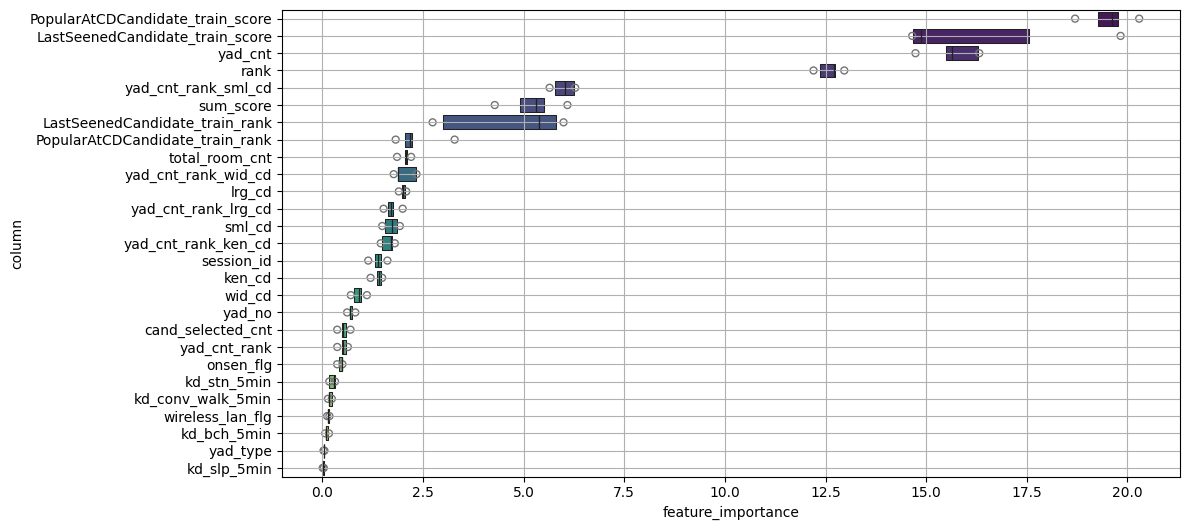

In [131]:
from scorta.eda import df as eda_df

eda_df.visualize_importance(gbdt.feature_importance(), X_train.to_pandas())

In [139]:
cd_cols = [
    "wid_cd",
    "ken_cd",
    "lrg_cd",
    "sml_cd",
]
test_pdf = test_df.to_pandas()
test_pdf.loc[:, cd_cols] = test_pdf[cd_cols].astype(int)
test_pdf.columns

Index(['session_id', 'yad_no', 'LastSeenedCandidate_test_score',
       'LastSeenedCandidate_test_rank', 'PopularAtCDCandidate_test_score',
       'PopularAtCDCandidate_test_rank', 'cand_selected_cnt', 'sum_score',
       'rank', 'yad_type', 'total_room_cnt', 'wireless_lan_flg', 'onsen_flg',
       'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min',
       'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'yad_cnt', 'yad_cnt_rank',
       'yad_cnt_rank_wid_cd', 'yad_cnt_rank_ken_cd', 'yad_cnt_rank_lrg_cd',
       'yad_cnt_rank_sml_cd', 'user_mode_wid_cd', 'user_mode_ken_cd',
       'user_mode_lrg_cd', 'user_mode_sml_cd', 'user_seq_cnt',
       'user_mean_total_room_cnt', 'user_mean_wireless_lan_flg',
       'user_mean_onsen_flg', 'user_mean_kd_stn_5min', 'user_mean_kd_bch_5min',
       'user_mean_kd_slp_5min', 'user_mean_kd_conv_walk_5min'],
      dtype='object')

In [140]:
import numpy as np

preds = np.array([gbdt.predict(test_pdf, i) for i in range(5)]).mean(axis=0)
sub = test_df.with_columns(pl.Series(preds).alias("score"))[["session_id", "yad_no", "score"]]

<Axes: ylabel='Count'>

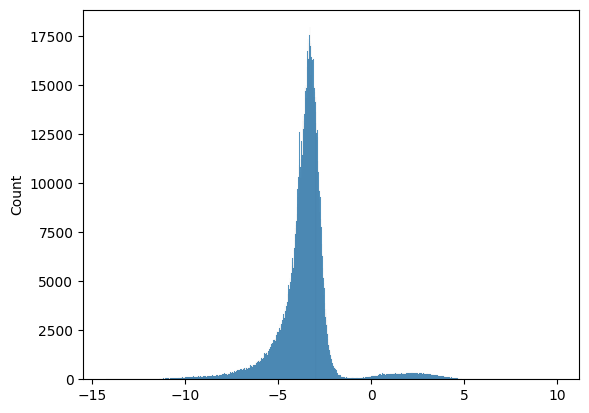

In [141]:
import seaborn as sns

sns.histplot(preds)

<Axes: ylabel='Count'>

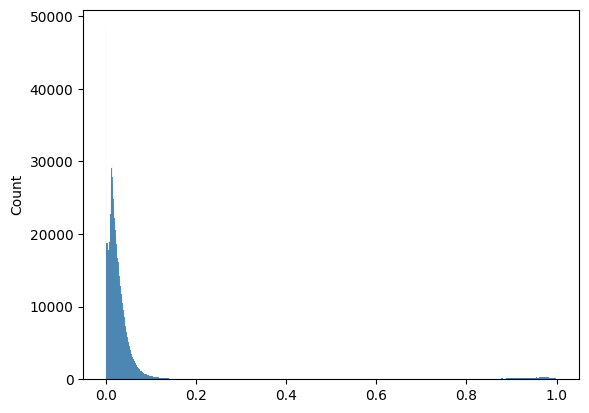

In [142]:
sns.histplot(oof[:, 1])

In [143]:
sub_lists = (
    sub.with_columns(
        pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
    )
    .sort(["session_id", "rank"])
    .filter(pl.col("rank") <= 9)
    .group_by("session_id", maintain_order=True)
    .agg("yad_no")["yad_no"]
    .to_list()
)

In [144]:
# (sub.with_columns(
#     pl.col("score").rank(method="ordinal", descending=True).over("session_id").alias("rank") - pl.lit(1)
# )
# .sort(["session_id", "rank"])
# .filter(pl.col("rank") <= 9)
# .group_by("session_id", maintain_order=True)
# .agg("yad_no"))

In [145]:
test_top30_yads = (
    dl.load_test_log().group_by("yad_no").count().sort("count", descending=True).head(30)["yad_no"].to_list()
)

seened_dict: dict[int, np.ndarray] = (
    dl.load_test_log()
    .with_columns([(pl.col("seq_no").max().over("session_id") == pl.col("seq_no")).alias("is_last")])
    .filter(~pl.col("is_last"))
    .group_by("session_id")
    .agg("yad_no")
    .sort("session_id")
    .to_pandas()
    .set_index("session_id")
    .to_dict()["yad_no"]
)


fill_sub_lists = []
for idx, sub_list in enumerate(sub_lists):
    new_sub_list = []
    if sub_list != [None]:
        new_sub_list.extend(sub_list)

    if len(sub_list) < 10:
        if idx in seened_dict:
            new_sub_list.extend(list(seened_dict[idx]))
        new_sub_list.extend(test_top30_yads[:10])

    fill_sub_lists.append(new_sub_list[:10])

In [146]:
np.array(fill_sub_lists).shape

(174700, 10)

In [147]:
sample_sub_df = dl.load_sample_submission("pd")
sample_sub_df.loc[:, :] = np.array(fill_sub_lists)
sample_sub_df.to_csv(f"../output/{exp_name}/sub_df_{oof_score}_add_feat.csv", index=False)